**IMPORT DATASET**

In [32]:
# Install dependencies as needed:
# pip install kagglehub[pandas-datasets]
!pip3 install torch torchvision
import kagglehub
from kagglehub import KaggleDatasetAdapter
import pandas as pd
import numpy as np

# Set the path to the file you'd like to load
file_path = "card_transdata.csv"

# Load the latest version
df = kagglehub.dataset_load(
  KaggleDatasetAdapter.PANDAS,
  "dhanushnarayananr/credit-card-fraud",
  file_path,
  # Provide any additional arguments like
  # sql_query or pandas_kwargs. See the
  # documenation for more information:
  # https://github.com/Kaggle/kagglehub/blob/main/README.md#kaggledatasetadapterpandas
)

Using Colab cache for faster access to the 'credit-card-fraud' dataset.


**CLEANUP** (redundant because dataset is already clean)

In [33]:
# cleaning
print(df.shape[0])
df.dropna(how='any')
df.drop_duplicates()
print(df.shape[0])

1000000
1000000


**EDA**

NUM FRAUDULENT TRANSACTIONS 87403/1000000 or 8.7403%
AVERAGE DISTANCE FROM HOME 26.62879219257128
MEDIAN DISTANCE FROM HOME 9.967760078697681


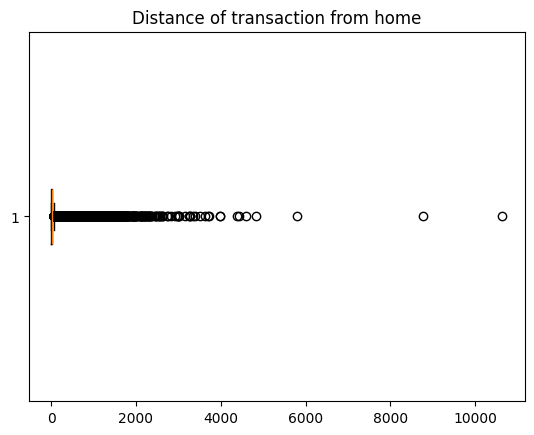

In [34]:
import matplotlib.pyplot as plt

frauds = df['fraud'][df['fraud'] == 1]
print('NUM FRAUDULENT TRANSACTIONS', f'{len(frauds)}' + '/' + f'{df.shape[0]}' + ' or ' + f'{ 100 * len(frauds) / df.shape[0]}%')
print('AVERAGE DISTANCE FROM HOME', df['distance_from_home'].mean())
print('MEDIAN DISTANCE FROM HOME', df['distance_from_home'].median())
plt.boxplot('distance_from_home', orientation='horizontal', data=df)
plt.title('Distance of transaction from home')
plt.show()


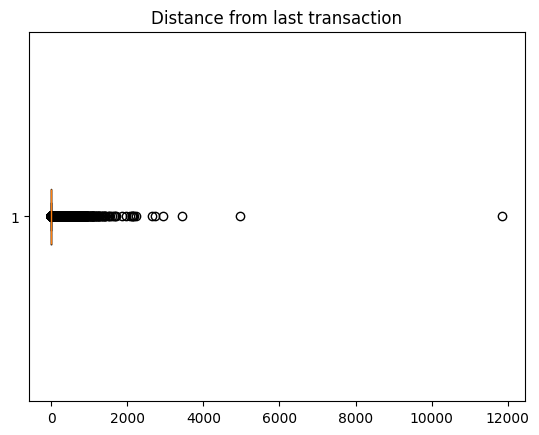

In [35]:
plt.boxplot('distance_from_last_transaction', orientation='horizontal', data=df)
plt.title('Distance from last transaction')
plt.show()

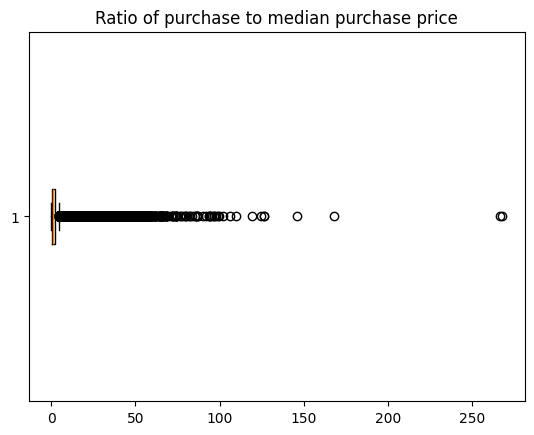

In [36]:
plt.boxplot('ratio_to_median_purchase_price', orientation='horizontal', data=df)
plt.title('Ratio of purchase to median purchase price')
plt.show()

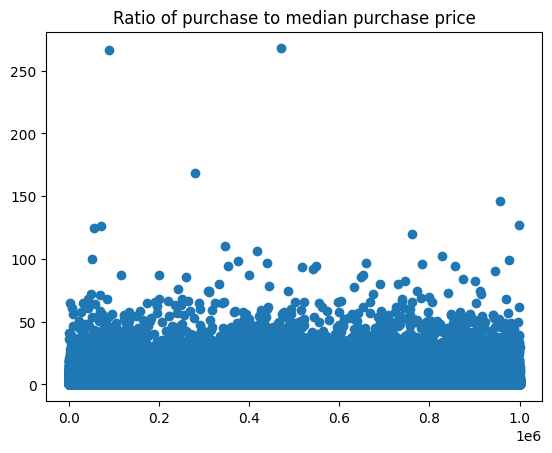

In [37]:
# going to visualize the purchase ratios as a scatter plot to better understand the distribution
plt.scatter(np.arange(df.shape[0]), 'ratio_to_median_purchase_price', data=df)
plt.title('Ratio of purchase to median purchase price')
plt.show()

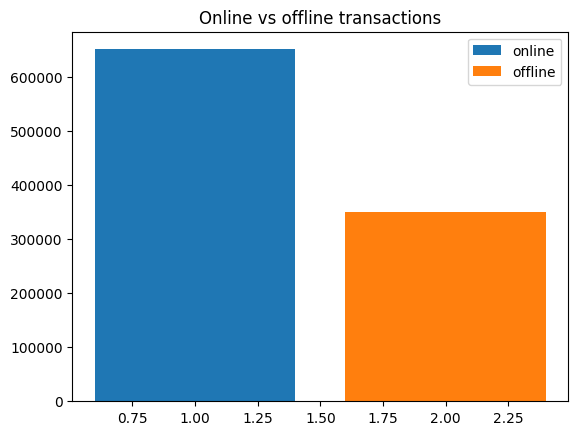

In [38]:
num_online = df[df['online_order'] == 1]
num_offline = df[df['online_order'] == 0]
plt.bar(1, len(num_online), label='online')
plt.bar(2, len(num_offline), label='offline')
plt.title('Online vs offline transactions')
plt.legend()
plt.show()

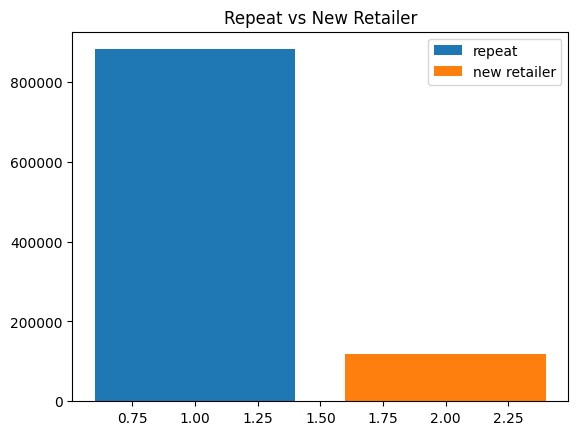

In [39]:
repeat = df[df['repeat_retailer'] == 1]
not_repeat = df[df['repeat_retailer'] == 0]
plt.bar(1, len(repeat), label='repeat')
plt.bar(2, len(not_repeat), label='new retailer')
plt.title('Repeat vs New Retailer')
plt.legend()
plt.show()

This is actually a very interesting statistic. 88% of transactions are repeats, then there are likely a large number of fraudulent transactions in non-repeat purchases.

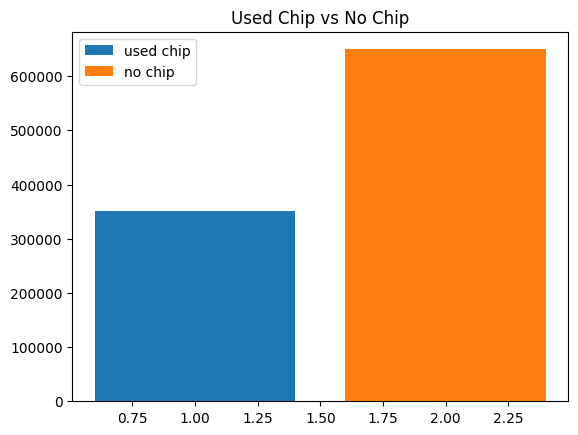

In [40]:
used_chip = df[df['used_chip'] == 1]
no_chip = df[df['used_chip'] == 0]
plt.bar(1, len(used_chip), label='used chip')
plt.bar(2, len(no_chip), label='no chip')
plt.title('Used Chip vs No Chip')
plt.legend()
plt.show()

In [41]:
print(df.describe())

       distance_from_home  distance_from_last_transaction  \
count      1000000.000000                  1000000.000000   
mean            26.628792                        5.036519   
std             65.390784                       25.843093   
min              0.004874                        0.000118   
25%              3.878008                        0.296671   
50%              9.967760                        0.998650   
75%             25.743985                        3.355748   
max          10632.723672                    11851.104565   

       ratio_to_median_purchase_price  repeat_retailer       used_chip  \
count                  1000000.000000   1000000.000000  1000000.000000   
mean                         1.824182         0.881536        0.350399   
std                          2.799589         0.323157        0.477095   
min                          0.004399         0.000000        0.000000   
25%                          0.475673         1.000000        0.000000   
50%   

It looks like the following features will be really key in determining whether there is fraud:

*   distance_from_home
*   distance_from_last_transaction
*   ratio_to_median_purchase_price
*   repeat_retailer



In [42]:
print(df['distance_from_home'].describe())
fraud_and_far_75 = df[(df['fraud'] == 1) & (df['distance_from_home'] > 25.743985)]
fraud_and_far_50 = df[(df['fraud'] == 1) & (df['distance_from_home'] > 9.967760)]
fraud_and_far_25 = df[(df['fraud'] == 1) & (df['distance_from_home'] > 3.878008)]
print('PERCENT OF FRAUDULENT TRANSACTIONS THAT WERE MORE THAN 75% QUARTILE DISTANCE FROM HOME', 100 * len(fraud_and_far_75) / len(frauds))
print('PERCENT OF FRAUDULENT TRANSACTIONS THAT WERE MORE THAN 50% QUARTILE DISTANCE FROM HOME', 100 * len(fraud_and_far_50) / len(frauds))
print('PERCENT OF FRAUDULENT TRANSACTIONS THAT WERE MORE THAN 50% QUARTILE DISTANCE FROM HOME', 100 * len(fraud_and_far_25) / len(frauds))

count    1000000.000000
mean          26.628792
std           65.390784
min            0.004874
25%            3.878008
50%            9.967760
75%           25.743985
max        10632.723672
Name: distance_from_home, dtype: float64
PERCENT OF FRAUDULENT TRANSACTIONS THAT WERE MORE THAN 75% QUARTILE DISTANCE FROM HOME 40.480303879729526
PERCENT OF FRAUDULENT TRANSACTIONS THAT WERE MORE THAN 50% QUARTILE DISTANCE FROM HOME 59.13984645835955
PERCENT OF FRAUDULENT TRANSACTIONS THAT WERE MORE THAN 50% QUARTILE DISTANCE FROM HOME 78.00418749928492


As we can see here, while distance from home is very helpful, it is not all-encompassing. Some of the fraudulent transactions were still very close to home.

In [43]:
print(df['distance_from_last_transaction'].describe())
lfraud_and_far_75 = df[(df['fraud'] == 1) & (df['distance_from_last_transaction'] > 3.355748)]
lfraud_and_far_50 = df[(df['fraud'] == 1) & (df['distance_from_last_transaction'] > 0.998650)]
lfraud_and_far_25 = df[(df['fraud'] == 1) & (df['distance_from_last_transaction'] > 0.296671)]
print('PERCENT OF FRAUDULENT TRANSACTIONS THAT WERE MORE THAN 75% QUARTILE DISTANCE FROM LAST TRANSACTION', 100 * len(lfraud_and_far_75) / len(frauds))
print('PERCENT OF FRAUDULENT TRANSACTIONS THAT WERE MORE THAN 50% QUARTILE DISTANCE FROM LAST TRANSACTION', 100 * len(lfraud_and_far_50) / len(frauds))
print('PERCENT OF FRAUDULENT TRANSACTIONS THAT WERE MORE THAN 50% QUARTILE DISTANCE FROM LAST TRANSACTION', 100 * len(lfraud_and_far_25) / len(frauds))

count    1000000.000000
mean           5.036519
std           25.843093
min            0.000118
25%            0.296671
50%            0.998650
75%            3.355748
max        11851.104565
Name: distance_from_last_transaction, dtype: float64
PERCENT OF FRAUDULENT TRANSACTIONS THAT WERE MORE THAN 75% QUARTILE DISTANCE FROM LAST TRANSACTION 29.818198460007093
PERCENT OF FRAUDULENT TRANSACTIONS THAT WERE MORE THAN 50% QUARTILE DISTANCE FROM LAST TRANSACTION 53.156070157774906
PERCENT OF FRAUDULENT TRANSACTIONS THAT WERE MORE THAN 50% QUARTILE DISTANCE FROM LAST TRANSACTION 76.72276695307941


These statistics echo the above ones, that distance is helpful, but not all-encompassing. This statistic is actually less helpful than the previous one.

In [44]:
print(df['ratio_to_median_purchase_price'].describe())
fraud_and_ratio_75 = df[(df['fraud'] == 1) & (df['distance_from_last_transaction'] > 2.096370)]
fraud_and_ratio_50 = df[(df['fraud'] == 1) & (df['distance_from_last_transaction'] > 0.997717)]
fraud_and_ratio_25 = df[(df['fraud'] == 1) & (df['distance_from_last_transaction'] > 0.475673)]
print('PERCENT OF FRAUDULENT TRANSACTIONS THAT WERE MORE THAN 75% QUARTILE DISTANCE FROM LAST TRANSACTION', 100 * len(fraud_and_ratio_75) / len(frauds))
print('PERCENT OF FRAUDULENT TRANSACTIONS THAT WERE MORE THAN 50% QUARTILE DISTANCE FROM LAST TRANSACTION', 100 * len(fraud_and_ratio_50) / len(frauds))
print('PERCENT OF FRAUDULENT TRANSACTIONS THAT WERE MORE THAN 50% QUARTILE DISTANCE FROM LAST TRANSACTION', 100 * len(fraud_and_ratio_25) / len(frauds))

count    1000000.000000
mean           1.824182
std            2.799589
min            0.004399
25%            0.475673
50%            0.997717
75%            2.096370
max          267.802942
Name: ratio_to_median_purchase_price, dtype: float64
PERCENT OF FRAUDULENT TRANSACTIONS THAT WERE MORE THAN 75% QUARTILE DISTANCE FROM LAST TRANSACTION 38.1886205278995
PERCENT OF FRAUDULENT TRANSACTIONS THAT WERE MORE THAN 50% QUARTILE DISTANCE FROM LAST TRANSACTION 53.173232040090156
PERCENT OF FRAUDULENT TRANSACTIONS THAT WERE MORE THAN 50% QUARTILE DISTANCE FROM LAST TRANSACTION 68.25509421873392


This statistic is almost as significant as the distance from home statistic, with almost 40% of fraudulent purchases being greater than the 75% percentile.

In [45]:
print(df['repeat_retailer'].describe())
fraud_and_not_repeat = df[(df['fraud'] == 1) & (df['repeat_retailer'] == 0)]
fraud_and_repeat = df[(df['fraud'] == 1) & (df['repeat_retailer'] == 1)]
print('PERCENT OF FRAUDULENT TRANSACTIONS THAT WERE NOT AT REPEAT RETAILERS', 100 * len(fraud_and_not_repeat) / len(frauds))
print('PERCENT OF FRAUDULENT TRANSACTIONS THAT WERE AT REPEAT RETAILERS', 100 * len(fraud_and_repeat) / len(frauds))

count    1000000.000000
mean           0.881536
std            0.323157
min            0.000000
25%            1.000000
50%            1.000000
75%            1.000000
max            1.000000
Name: repeat_retailer, dtype: float64
PERCENT OF FRAUDULENT TRANSACTIONS THAT WERE NOT AT REPEAT RETAILERS 11.9881468599476
PERCENT OF FRAUDULENT TRANSACTIONS THAT WERE AT REPEAT RETAILERS 88.0118531400524


Okay, it looks like the majority of frauds were at repeat retailers. This statistic may be helpful, but it is not going to play a huge role.

In [46]:
# going to try other statistics as well
print(df['used_chip'].describe())
fraud_and_chip = df[(df['fraud'] == 1) & (df['used_chip'] == 1)]
print('PERCENT OF FRAUDULENT TRANSACTIONS THAT USED CHIP', 100 * len(fraud_and_chip) / len(frauds))

count    1000000.000000
mean           0.350399
std            0.477095
min            0.000000
25%            0.000000
50%            0.000000
75%            1.000000
max            1.000000
Name: used_chip, dtype: float64
PERCENT OF FRAUDULENT TRANSACTIONS THAT USED CHIP 25.63985217898699


In [47]:
print(df['used_pin_number'].describe())
fraud_and_pin = df[(df['fraud'] == 1) & (df['used_pin_number'] == 1)]
print('PERCENT OF FRAUDULENT TRANSACTIONS THAT USED PIN', 100 * len(fraud_and_pin) / len(frauds))

count    1000000.000000
mean           0.100608
std            0.300809
min            0.000000
25%            0.000000
50%            0.000000
75%            0.000000
max            1.000000
Name: used_pin_number, dtype: float64
PERCENT OF FRAUDULENT TRANSACTIONS THAT USED PIN 0.31234625813759254


In [48]:
print(df['online_order'].describe())
fraud_and_online = df[(df['fraud'] == 1) & (df['online_order'] == 1)]
print('PERCENT OF FRAUDULENT TRANSACTIONS THAT WERE ONLINE', 100 * len(fraud_and_online) / len(frauds))

count    1000000.000000
mean           0.650552
std            0.476796
min            0.000000
25%            0.000000
50%            1.000000
75%            1.000000
max            1.000000
Name: online_order, dtype: float64
PERCENT OF FRAUDULENT TRANSACTIONS THAT WERE ONLINE 94.63176321178906


Okay, big breakthrough here. Most of the fraudulent transactions (95%) were online. But I'm confused as to why 25% of fraudulent transactions also used chip...let's explore that next.

In [49]:
fraud_and_online_and_chip = df[(df['fraud'] == 1) & (df['online_order'] == 1) & (df['used_chip'] == 1)]
print('PERCENT OF FRAUDULENT TRANSACTIONS THAT WERE ONLINE AND USED CHIP', 100 * len(fraud_and_online_and_chip) / len(frauds))

PERCENT OF FRAUDULENT TRANSACTIONS THAT WERE ONLINE AND USED CHIP 24.711966408475682


This doesn't make any sense. There shouldn't be an overlap of online transactions and chip transactions, you have to be in-person to use chip. The Kaggle page has (credit card) in parentheses next to this feature, so maybe that's what it is.

**FEATURE CORRELATIONS**

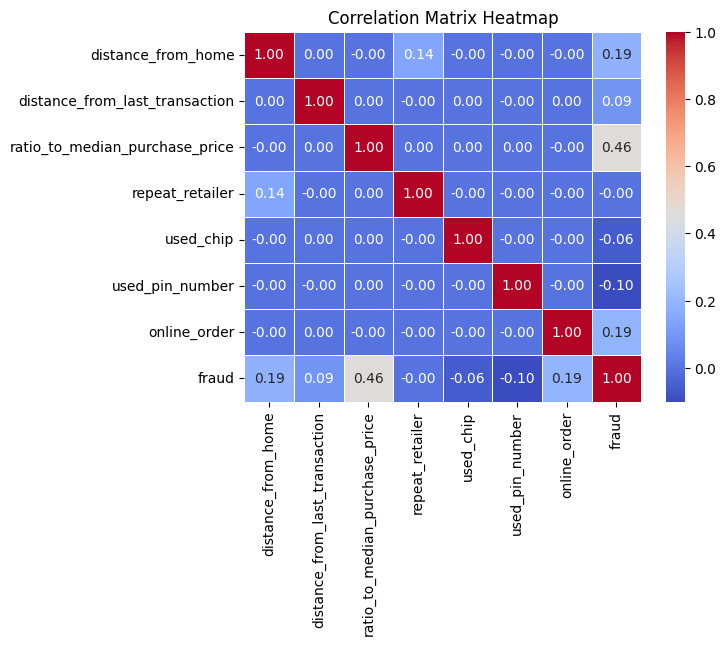

In [50]:
import seaborn as sns

correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

This makes sense because fraudulent orders only account for 8% of all transactions.

**BUILD THE NETWORK**

In [51]:
# we are going to use a neural network, because it seems as thought there are non-linear combinations of features that may be useful for identifying fraud
import torch
from torch import nn

device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

class FraudDetectionNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(7, 14),
            nn.ReLU(),
            nn.Linear(14, 28),
            nn.ReLU(),
            nn.Linear(28, 14),
            nn.ReLU(),
            nn.Linear(14, 2),
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits


model = FraudDetectionNetwork().to(device)

Using cuda device


**TRAIN THE NETWORK**

In [52]:
# train the model on our data
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler # we are using this module to address the imbalance in our data
from torch.utils.data import TensorDataset, DataLoader # going to learn in batches to keep gradient stable


X = df.drop(columns=['fraud'])
y = df['fraud']

# split before resampling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y) # we stratify to preserve the ratio of classes

# apply undersampling to training data only, this will ensure we have a 50/50 class split in our training data
rus = RandomUnderSampler(sampling_strategy=1)
X_res, y_res = rus.fit_resample(X_train, y_train)

X_train_tensor = torch.tensor(X_res.values).float()
y_train_tensor = torch.tensor(y_res.values).float()
X_test_tensor = torch.tensor(X_test.values).float()
y_test_tensor = torch.tensor(y_test.values).float()

num_epochs = 100
learning_rate = 0.0001

model = FraudDetectionNetwork()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

# prepare dataloader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor.long())
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

avg_loss_over_time = []

for epoch in range(num_epochs):
    running_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {running_loss / len(train_loader):.4f}")
    avg_loss_over_time.append(running_loss / len(train_loader))


Epoch 1, Loss: 0.5915
Epoch 2, Loss: 0.4355
Epoch 3, Loss: 0.3416
Epoch 4, Loss: 0.3058
Epoch 5, Loss: 0.2851
Epoch 6, Loss: 0.2715
Epoch 7, Loss: 0.2633
Epoch 8, Loss: 0.2553
Epoch 9, Loss: 0.2484
Epoch 10, Loss: 0.2412
Epoch 11, Loss: 0.2350
Epoch 12, Loss: 0.2276
Epoch 13, Loss: 0.2251
Epoch 14, Loss: 0.2186
Epoch 15, Loss: 0.2124
Epoch 16, Loss: 0.2088
Epoch 17, Loss: 0.2044
Epoch 18, Loss: 0.2026
Epoch 19, Loss: 0.1972
Epoch 20, Loss: 0.1942
Epoch 21, Loss: 0.1905
Epoch 22, Loss: 0.1884
Epoch 23, Loss: 0.1853
Epoch 24, Loss: 0.1801
Epoch 25, Loss: 0.1759
Epoch 26, Loss: 0.1726
Epoch 27, Loss: 0.1779
Epoch 28, Loss: 0.1630
Epoch 29, Loss: 0.1600
Epoch 30, Loss: 0.1561
Epoch 31, Loss: 0.1482
Epoch 32, Loss: 0.1451
Epoch 33, Loss: 0.1388
Epoch 34, Loss: 0.1327
Epoch 35, Loss: 0.1264
Epoch 36, Loss: 0.1216
Epoch 37, Loss: 0.1179
Epoch 38, Loss: 0.1114
Epoch 39, Loss: 0.1079
Epoch 40, Loss: 0.1056
Epoch 41, Loss: 0.1034
Epoch 42, Loss: 0.1003
Epoch 43, Loss: 0.0980
Epoch 44, Loss: 0.09

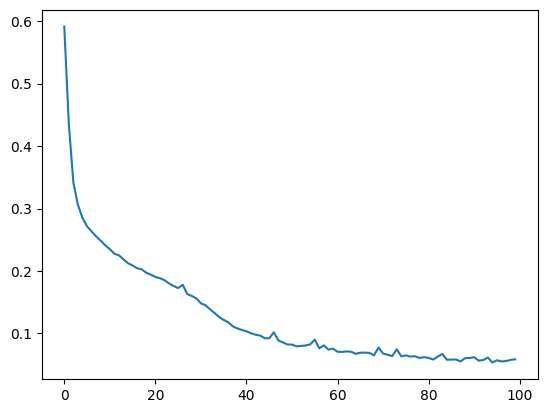

In [53]:
# graph the loss over time
plt.plot(avg_loss_over_time)

**TEST THE NETWORK**

In [54]:
print("Testing...")

model.eval()  # set model to eval mode to stop testing behavior at different layers
correct = 0

with torch.no_grad():  # disable gradient tracking since we are testing
    outputs = model(X_test_tensor)
    predictions = torch.argmax(outputs, dim=1)
    correct = (predictions == y_test_tensor.long()).sum().item()

accuracy = correct / len(y_test_tensor)
print(f"Accuracy: {accuracy:.4f}")

Testing...
Accuracy: 0.9725
